In [1]:
import numpy as np
import scipy.ndimage
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Dictionary to map file keys from STScI to Krist

In [2]:
telap_key_map = {'hex1':'hex1', 'hex2':'hex2', 'hex3':'hex3', 'hex4':'hex4',
                 'key24':'keystone24', 'pie08':'piewedge8', 'pie12':'piewedge12'}
secobs_key_map = {'Cross':'cross', 'X':'x'}

## Set basic parameters

In [3]:
N = 300
inD = 0.30
outD = 0.9
spad = 0.01
telap_key = "hex3"
secobs_key = "Cross"
D = 1000

## Load an example telescope aperture and secondary obscuration

In [4]:
#telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
telap_dir = os.path.abspath('/astro/opticslab1/SCDA/Apertures/JPL/offset_masks')
telap_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset.fits".format(telap_key_map[telap_key], D))
secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(secobs_key_map[secobs_key],
                                                                                           D))
telap_hdulist = fits.open(telap_fname, "readonly")
telap_orig = telap_hdulist[0].data
telap_hdulist.close()
secobs_hdulist = fits.open(secobs_fname, "readonly")
secobs = secobs_hdulist[0].data
secobs_hdulist.close()

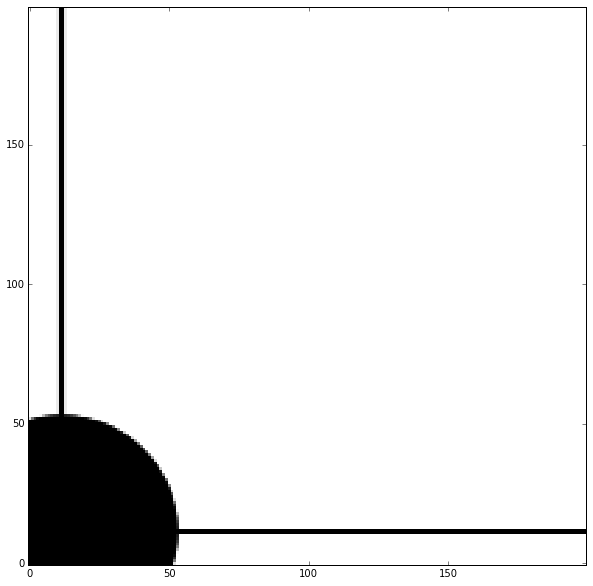

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(secobs[500:700,500:700])

## Pad the secondary obscuration

In [6]:
max_shift = int(round(D*spad))
shift_range = range(-max_shift,max_shift+1,1)

In [7]:
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)

In [8]:
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)

In [9]:
allowed_shifts.shape

(21, 21)

In [10]:
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])

In [11]:
len(XYshifts_allowed)

317

In [12]:
padded_secobs_accum = np.ones(secobs.shape)
for (xshift,yshift) in XYshifts_allowed:
    secobs_shifted = np.roll(np.roll(secobs, yshift, 0), xshift, 1) 
    padded_secobs_accum *= secobs_shifted

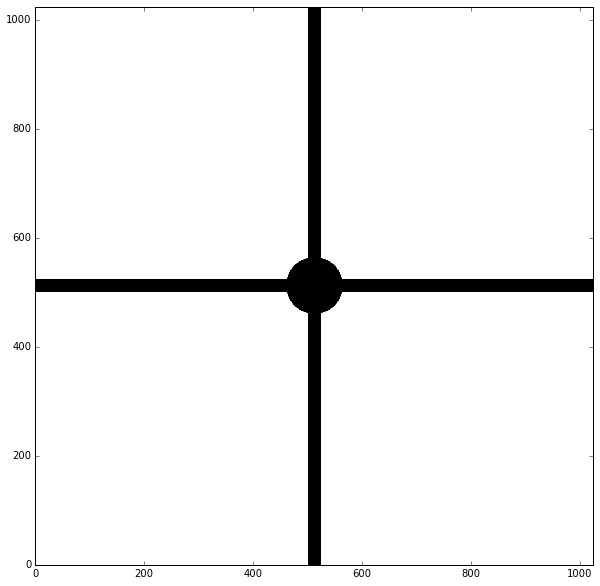

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(padded_secobs_accum)

## Combine with annular stop

In [14]:
L = secobs.shape[0]
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)
inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
Lyot_stop = np.round(padded_secobs_accum)
Lyot_stop[inside_ann] = 0.
Lyot_stop[outside_ann] = 0.

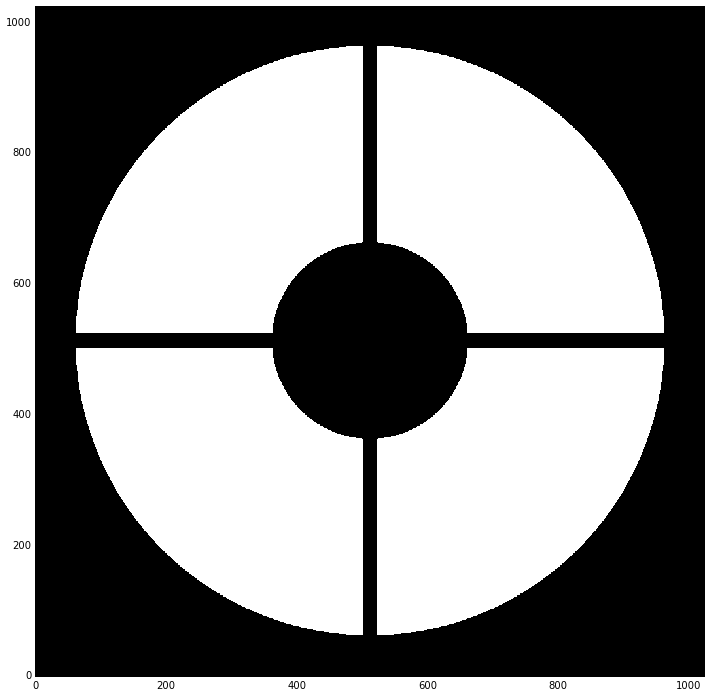

In [15]:
plt.figure(figsize=(12,12))
plt.imshow(Lyot_stop)

## Bin to final array resolution, crop

In [16]:
scalefac = float(N)/(D/2)
Lyot_stop_binned = scipy.ndimage.zoom(Lyot_stop, scalefac, order=1)

In [17]:
L_bin = Lyot_stop_binned.shape[0]
Lyot_stop_binned_quad = Lyot_stop_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
Lyot_stop_binned_quad.shape

(300, 300)

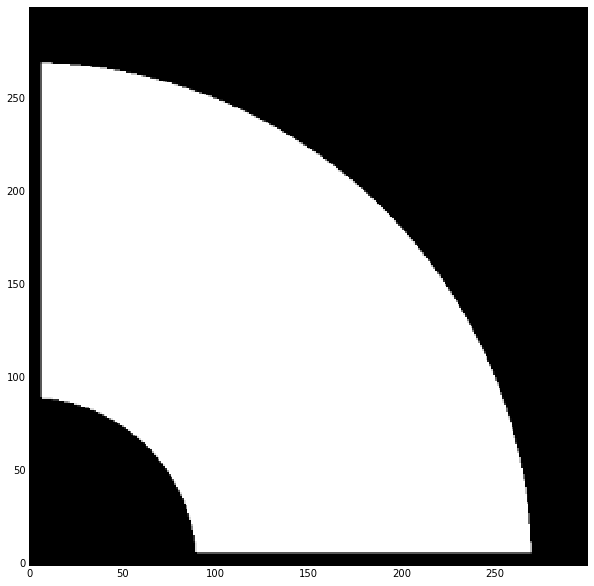

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(Lyot_stop_binned_quad)

## Write the binned, cropped Lyot stop to a dat (ASCII) file 

In [19]:
LS_dir = os.path.abspath("../LS")
if not os.path.exists(LS_dir):
    os.mkdir(LS_dir)
    print("created {:s} for LS arrays".format(LS_dir))
else:
    print("Destination {:s} already exists".format(LS_dir))

Destination /Users/ntz/SCDA/LS already exists


In [20]:
#LS_quart_dat_fname_tail = "LS_quart_ann{0:02d}D{1:02d}_clear_N{2:04d}.dat".format(int(round(100*inD)),
#                                                                                  int(round(100*outD)),
#                                                                                  N)
LS_quart_dat_fname_tail = "LS_quart_ann{0:02d}D{1:02d}_{2:s}025sm1Pad{3:02d}_N{4:04d}.dat".format(int(round(100*inD)),
                                                                                                  int(round(100*outD)),
                                                                                                  secobs_key,
                                                                                                  int(round(100*spad)),
                                                                                                  N)
LS_quart_dat_fname = os.path.join(LS_dir, LS_quart_dat_fname_tail)
np.savetxt(LS_quart_dat_fname, Lyot_stop_binned_quad, fmt='%.6f', delimiter=" ")
print("Wrote binned, cropped LS array to {0:s}".format(LS_quart_dat_fname))

Wrote binned, cropped LS array to /Users/ntz/SCDA/LS/LS_quart_ann30D90_Cross025sm1Pad01_N0300.dat


In [21]:
os.listdir(LS_dir)

['LS_quart_ann25D90_Cross025sm1Pad01_N0300.dat',
 'LS_quart_ann25D90_Cross025sm1Pad02_N0300.dat',
 'LS_quart_ann25D90_X025sm1Pad01_N0300.dat',
 'LS_quart_ann25D90_X025sm1Pad02_N0300.dat',
 'LS_quart_ann30D90_Cross025sm1Pad01_N0300.dat',
 'LS_quart_ann30D90_Cross025sm1Pad02_N0300.dat',
 'LS_quart_ann30D90_X025sm1Pad01_N0300.dat',
 'LS_quart_ann30D90_X025sm1Pad02_N0300.dat']